In [23]:
import numpy as np

import scipy as sp
import scipy.sparse
import scipy.sparse.linalg

import sklearn
import sklearn.preprocessing

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import time

In [2]:
A = sp.sparse.csr_matrix(np.load("A.npy"))
d = np.zeros(A.shape[0])

for i in range(25):
    d[np.random.randint(0, A.shape[0])] = np.random.randint(-1, 2)

In [4]:
# preprocessing

F = sklearn.preprocessing.normalize(A, axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T, axis=1, norm='l1')

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [5]:
a1 = 0.7
a2 = 0.7
a3 = 0.7

In [6]:
# we are looking for solution x == T(x)

def T(F, B, d, x):
    return a1 * F.dot(x.clip(0)) + a2 * B.dot(x.clip(-np.inf, 0)) + a3 * d

In [7]:
def h(x):
    ans = np.zeros_like(x)
    ans[x > 0.0] = 1.0
    return ans

In [8]:
def obj(F, B, d, x):
    return np.linalg.norm(x - T(F, B, d, x)) ** 2 / 2

In [9]:
def Jac(F, B, d, x):
    return sp.sparse.eye(F.shape[0], format='csr') - a1 * F.multiply(sp.sparse.csc_matrix(h(x).reshape(-1, 1))) - a2 * B.multiply(sp.sparse.csc_matrix(h(-x).reshape(-1, 1)))

In [10]:
def der(F, B, d, x):
    l = x - T(F, B, d, x)
    return Jac(F, B, d, x).T.dot(l)

In [11]:
def Hess(F, B, d, x):
    return Jac(F, B, d, x).T.dot(Jac(F, B, d, x))

In [19]:
def VanillaNewton(F, B, d, maxiter=200, x0=None, tol=1e-8):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        dx, info = sp.sparse.linalg.gmres(Hess(F, B, d, x_prev), -der(F, B, d, x_prev))
        x_next = x_prev + dx
        if obj(F, B, d, x_next) < tol:
            break
        x_prev = x_next.copy()

    ans = x_next.copy()
    return k + 1, ans

In [25]:
tt = np.empty(100)

for i in range(len(tt)):
    begin = time.time()
    k, ans_VN = VanillaNewton(F, B, d)
    end = time.time()
    tt[i] = end - begin

print(np.mean(tt), np.std(tt, ddof=1))

1.11321367264 0.0299013301275


In [48]:
VN_mean = np.empty(10)
VN_var = np.empty(10)
j = 0

for i in np.logspace(0, -8, num=10):

    tt = np.empty(30)

    for k in range(len(tt)):
        begin = time.time()
        k, ans = VanillaNewton(F, B, d, tol=i)
        end = time.time()
        tt[k] = end - begin

    VN_mean[j] = np.mean(tt)
    VN_var[j] = np.std(tt, ddof=1)
    j += 1

In [15]:
# RepRank

def RepRank(F, B, d, maxiter=200, x0=None, tol=1e-8):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        x_next = T(F, B, d, x_prev)
        if obj(F, B, d, x_next) < tol:
            break
        x_prev = x_next

    ans = x_next.copy()
    return k + 1, ans

In [24]:
tt = np.empty(100)

for i in range(len(tt)):
    begin = time.time()
    k, ans_RR = RepRank(F, B, d)
    end = time.time()
    tt[i] = end - begin

print(np.mean(tt), np.std(tt, ddof=1))

0.0135707759857 0.00231936306277


In [43]:
RR_mean = np.empty(10)
RR_var = np.empty(10)
j = 0

for i in np.logspace(0, -8, num=10):

    tt = np.empty(30)

    for k in range(len(tt)):
        begin = time.time()
        k, ans = RepRank(F, B, d, tol=i)
        end = time.time()
        tt[k] = end - begin

    RR_mean[j] = np.mean(tt)
    RR_var[j] = np.std(tt, ddof=1)
    j += 1

In [53]:
VN_var

array([ 0.00328653,  0.00693644,  0.01533028,  0.03229697,  0.05520742,
        0.0766028 ,  0.10447568,  0.13257602,  0.16921695,  0.22795559])

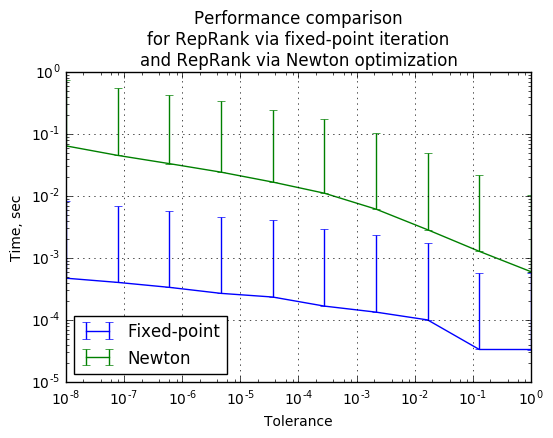

In [57]:
plt.errorbar(np.logspace(0, -8, num=10), RR_mean, yerr=[np.zeros_like(RR_var), 3 * RR_var], label="Fixed-point")
#plt.plot(np.logspace(0, -11), RR_mean, label="Fixed-point")
plt.errorbar(np.logspace(0, -8, num=10), VN_mean, yerr=[np.zeros_like(VN_var), 3 * VN_var], label="Newton")
#plt.plot(np.logspace(0, -11), N_mean, label="Newton")

plt.xscale("log")
plt.xlabel("Tolerance")
plt.yscale("log")
plt.ylabel("Time, sec")
plt.title("Performance comparison\nfor RepRank via fixed-point iteration\nand RepRank via Newton optimization")
plt.grid()
plt.legend(loc="best")
plt.show()

In [12]:
def LineSearch(x, dx):
    alpha = obj(x) / np.linalg.norm(dx) ** 2
    while True:
        if obj(x + alpha * dx) < obj(x):
            return x + alpha * dx
        else:
            alpha /= 2